# Advanced Assessment

Data Source **https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository/data**

In [25]:
from statsmodels.tools.sm_exceptions import ValueWarning
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import dataclass_transform
from utils.plot_time_series import filter_data_country_location
import ipywidgets as widgets
from IPython.display import display
import warnings
from utils.plot_time_series import filter_data_country_location
from utils.anomalies_helpers import update_plot_with_anomalies

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels.tsa.base.tsa_model")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels.tsa.base.tsa_model")

In [16]:
# read the csv data 
data = pd.read_csv('data/GlobalWeatherRepository_filtered.csv')
data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


**Advanced EDA** <br> Anomaly detection to identify and analyze outliers.


In [17]:
# convery the last_updated column to datetime
data['last_updated'] = pd.to_datetime(data['last_updated'])

In [18]:
# Function to update the plot based on the selected country, location, and field
def update_plot(country, location_name, field):
    data_filtered = filter_data_country_location(data, country, location_name)
    y = data_filtered[field]
    x = data_filtered['last_updated']

    plt.figure(figsize=(10, 6))  # Adjust the plot size
    plt.plot(x, y, color='blue')
    plt.title(f'{field.replace("_", " ").title()} Time Series - {country}, {location_name}')
    plt.xlabel('Date')
    plt.ylabel(field.replace("_", " ").title())
    plt.show()

# Create a dropdown widget for selecting the country
country_dropdown = widgets.Dropdown(
    options=data['country'].unique(),
    description='Country:',
    value='United States of America',
    layout=widgets.Layout(width='200px')  # Set fixed width
)

# Create a dropdown widget for selecting the location
location_dropdown = widgets.Dropdown(
    options=data[data['country'] == 'United States of America']['location_name'].unique(),
    description='Location:',
    value='Washington Harbor',
    layout=widgets.Layout(width='200px')  # Set fixed width
)

# Create a dropdown widget for selecting the field
field_dropdown = widgets.Dropdown(
    options=[
        'temperature_celsius', 'temperature_fahrenheit',
        'wind_mph', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in',
        'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
        'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
        'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
        'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination'
    ],
    description='Field:',
    value='temperature_fahrenheit',
    layout=widgets.Layout(width='200px')  # Set fixed width
)

# Update the location dropdown options based on the selected country
def update_location_options(*args):
    selected_country = country_dropdown.value
    location_dropdown.options = data[data['country'] == selected_country]['location_name'].unique()

country_dropdown.observe(update_location_options, 'value')

# Create a VBox for the dropdowns
dropdowns = widgets.VBox([country_dropdown, location_dropdown, field_dropdown])

# Create an output widget for the plot
output = widgets.Output()

# Function to update the plot and display it in the output widget
def update_plot_and_display(*args):
    with output:
        output.clear_output(wait=True)
        update_plot(country_dropdown.value, location_dropdown.value, field_dropdown.value)

# Observe changes in the dropdowns to update the plot
country_dropdown.observe(update_plot_and_display, 'value')
location_dropdown.observe(update_plot_and_display, 'value')
field_dropdown.observe(update_plot_and_display, 'value')

# Display the dropdowns to the right of the plot
display(widgets.HBox([output, dropdowns]))

# Initial plot display
update_plot_and_display()

In [26]:
# Create a dropdown widget for anomaly detection model
model_dropdown = widgets.Dropdown(
    options=["IsolationForest", "K-Means"],
    description='Model:',
    value='IsolationForest',
    layout=widgets.Layout(width='200px')
)

# Create a button for anomaly detection
detect_button = widgets.Button(
    description="Detect Anomalies",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_detect_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_anomalies(
            data, output, country_dropdown.value, location_dropdown.value, field_dropdown.value, model_dropdown.value
        )

# Attach the event handler to the button
detect_button.on_click(on_detect_button_click)

# Create a VBox for the dropdowns and button
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, model_dropdown, detect_button])

# Display the controls to the right of the plot
display(widgets.HBox([output, controls]))

# Initial plot display
update_plot_and_display()

**Forecasting with Multiple Models**


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

field_dropdown = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['country', 'location_name']],
    description='Field:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for plots and messages
output = widgets.Output()


# Function to fit ARIMA and forecast
def forecast_with_arima(data, field, p, d, q, steps):
    values = data[field].dropna()
    train_size = int(len(values) * 0.8)
    train_data = values[:train_size]
    test_data = values[train_size:]

    # Fit ARIMA model
    model = ARIMA(train_data, order=(p, d, q))
    model_fitted = model.fit()

    # Forecast
    forecast = model_fitted.forecast(steps=steps)
    forecast_index = test_data.index[:steps] if len(test_data) >= steps else test_data.index

    mse = mean_squared_error(test_data[:steps], forecast) if len(test_data) >= steps else None
    return train_data, test_data, forecast, forecast_index, mse

# Function to update the plot with ARIMA forecast
def update_plot_with_forecast(country, location_name, field, p, d, q, steps):
    data_filtered = filter_data_country_location(data, country, location_name)
    y = data_filtered[field]
    x = data_filtered.index  # Use the index for plotting

    try:
        train_data, test_data, forecast, forecast_index, mse = forecast_with_arima(data_filtered, field, p, d, q, steps)
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error: {e}")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    if len(test_data) > 0:
        plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='dashed')
    plt.title(f'{field.replace("_", " ").title()} Forecast (ARIMA) - {country}, {location_name}')
    plt.xlabel('Date')
    plt.ylabel(field.replace("_", " ").title())
    plt.legend()
    plt.show()

    if mse is not None:
        print(f"Mean Squared Error: {mse:.4f}")
    else:
        print("Not enough test data to compute MSE.")

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Create sliders for ARIMA parameters
p_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description='q:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_forecast(
            country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value, steps_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for ARIMA controls
arima_controls = widgets.VBox([p_slider, d_slider, q_slider, steps_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, arima_controls])
display(widgets.HBox([output, controls]))

In [28]:
# SARIMA model
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

field_dropdown = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['country', 'location_name']],
    description='Field:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for plots and messages
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to fit SARIMA and forecast
def forecast_with_sarima(data, field, p, d, q, P, D, Q, s, steps):
    values = data[field].dropna()
    train_size = int(len(values) * 0.8)
    train_data = values[:train_size]
    test_data = values[train_size:]

    # Fit SARIMA model
    model = SARIMAX(
        train_data,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fitted = model.fit(disp=False)

    # Forecast
    forecast = model_fitted.forecast(steps=steps)
    forecast_index = test_data.index[:steps] if len(test_data) >= steps else test_data.index

    mse = mean_squared_error(test_data[:steps], forecast) if len(test_data) >= steps else None
    return train_data, test_data, forecast, forecast_index, mse

# Function to update the plot with SARIMA forecast
def update_plot_with_forecast(country, location_name, field, p, d, q, P, D, Q, s, steps):
    data_filtered = data[(data['country'] == country) & (data['location_name'] == location_name)]

    try:
        train_data, test_data, forecast, forecast_index, mse = forecast_with_sarima(
            data_filtered, field, p, d, q, P, D, Q, s, steps
        )
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error: {e}")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    if len(test_data) > 0:
        plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='dashed')
    plt.title(f'{field.replace("_", " ").title()} Forecast (SARIMA) - {country}, {location_name}')
    plt.xlabel('Date')
    plt.ylabel(field.replace("_", " ").title())
    plt.legend()
    plt.show()

    if mse is not None:
        print(f"Mean Squared Error: {mse:.4f}")
    else:
        print("Not enough test data to compute MSE.")

# Create sliders for SARIMA parameters
p_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='q:')
P_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='P:')
D_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='D:')
Q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='Q:')
season_slider = widgets.IntSlider(value=12, min=1, max=24, step=1, description='Seasonal Period:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_forecast(
            country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value,
            P_slider.value, D_slider.value, Q_slider.value,
            season_slider.value, steps_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for SARIMA controls
sarima_controls = widgets.VBox([
    p_slider, d_slider, q_slider, P_slider, D_slider, Q_slider, season_slider, steps_slider, forecast_button
])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, sarima_controls])
display(widgets.HBox([output, controls]))

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

field_dropdown = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['country', 'location_name', 'last_updated']],
    description='Field:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for plots and messages
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to prepare lagged features for time series forecasting
def create_lagged_features(data, field, lags):
    df = data[[field]].copy()
    for lag in range(1, lags + 1):
        df[f'{field}_lag_{lag}'] = df[field].shift(lag)
    df = df.dropna()
    return df

# Function to forecast using CatBoost within the test range
def forecast_with_catboost(data, field, lags):
    # Prepare lagged features
    df = create_lagged_features(data, field, lags)
    X = df.drop(columns=[field])
    y = df[field]

    # Split into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the CatBoost model
    model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, silent=True)
    model.fit(X_train, y_train)

    # Predict for the test range
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return y_train, y_test, predictions, mse

# Function to update the plot with CatBoost forecast
def update_plot_with_forecast(country, location_name, field, lags):
    data_filtered = data[(data['country'] == country) & (data['location_name'] == location_name)].copy()
    data_filtered = data_filtered.set_index('last_updated').sort_index()

    try:
        train_data, test_data, predictions, mse = forecast_with_catboost(
            data_filtered, field, lags
        )
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error: {e}")
        return

    with output:
        output.clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(train_data.index, train_data, label='Training Data', color='blue')
        plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
        plt.plot(test_data.index, predictions, label='Predicted Test Data', color='orange')
        plt.title(f'{field.replace("_", " ").title()} Forecast (CatBoost) - {country}, {location_name}')
        plt.xlabel('Date')
        plt.ylabel(field.replace("_", " ").title())
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Mean Squared Error: {mse:.4f}")

# Create slider for lag features
lags_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Lags:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    update_plot_with_forecast(
        country_dropdown.value, location_dropdown.value, field_dropdown.value,
        lags_slider.value
    )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for CatBoost controls
catboost_controls = widgets.VBox([lags_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, catboost_controls])
display(widgets.HBox([output, controls]))

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display


# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

field_dropdown = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['country', 'location_name']],
    description='Field:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for plots and messages
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# PyTorch LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Function to train and forecast using LSTM
def forecast_with_lstm(data, field, steps, epochs):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[field].dropna().values.reshape(-1, 1))

    # Prepare the data for LSTM
    sequence_length = 10  # Number of time steps
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = torch.FloatTensor(X).unsqueeze(2)  # Add a feature dimension
    y = torch.FloatTensor(y)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Define the LSTM model
    input_dim = 1
    hidden_dim = 50
    num_layers = 2
    output_dim = 1
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
    model = model.to(torch.device('cpu'))  # Change to 'cuda' if GPU is available

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(epochs):  # Use the input epochs here
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Make predictions
    model.eval()
    predictions = model(X_test).detach().numpy()
    predictions = scaler.inverse_transform(predictions)  # Scale back to original values
    y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))  # Scale back test values

    mse = mean_squared_error(y_test, predictions)

    # Prepare data for plotting
    train_data = scaler.inverse_transform(scaled_data[:train_size].reshape(-1, 1))
    test_data = y_test
    forecast_index = data.index[train_size + sequence_length:]

    return train_data, test_data, predictions, forecast_index, mse

# Function to update the plot with LSTM forecast
def update_plot_with_lstm(country, location_name, field, steps, epochs):
    data_filtered = filter_data_country_location(data, country, location_name)

    try:
        train_data, test_data, predictions, forecast_index, mse = forecast_with_lstm(data_filtered, field, steps, epochs)
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error: {e}")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(data_filtered.index[:len(train_data)], train_data, label='Training Data', color='blue')
    plt.plot(forecast_index, test_data, label='Actual Test Data', color='green')
    plt.plot(forecast_index, predictions, label='Forecast', color='red', linestyle='dashed')
    plt.title(f'{field.replace("_", " ").title()} Forecast (LSTM) - {country}, {location_name}')
    plt.xlabel('Date')
    plt.ylabel(field.replace("_", " ").title())
    plt.legend()
    plt.show()

    print(f"Mean Squared Error: {mse:.4f}")

# Create slider for forecast steps
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

# Create slider for training epochs
epochs_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='Epochs:')

# Create a button for forecasting
forecast_button = widgets.Button(
    description="Forecast",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the plot when the button is clicked
def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_lstm(
            country_dropdown.value, location_dropdown.value, field_dropdown.value,
            steps_slider.value, epochs_slider.value
        )

# Attach the event handler to the button
forecast_button.on_click(on_forecast_button_click)

# Create a VBox for LSTM controls
lstm_controls = widgets.VBox([steps_slider, epochs_slider, forecast_button])

# Display the controls and the output area
controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, lstm_controls])
display(widgets.HBox([output, controls]))

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
import torch
import ipywidgets as widgets
from IPython.display import display


# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

field_dropdown = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['country', 'location_name']],
    description='Field:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for plots and messages
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to prepare lagged features for CatBoost
def create_lagged_features(data, field, lags):
    df = data[[field]].copy()
    for lag in range(1, lags + 1):
        df[f'{field}_lag_{lag}'] = df[field].shift(lag)
    df = df.dropna()
    return df

# ARIMA model
def arima_forecast(train_data, steps, p, d, q):
    model = ARIMA(train_data, order=(p, d, q))
    model_fitted = model.fit()
    return model_fitted.forecast(steps=steps)

# SARIMA model
def sarima_forecast(train_data, steps, p, d, q, P, D, Q, s):
    model = SARIMAX(
        train_data,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fitted = model.fit(disp=False)
    return model_fitted.forecast(steps=steps)


# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def lstm_forecast(data, field, lags, steps):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[field].dropna().values.reshape(-1, 1))

    # Prepare the data for LSTM
    X, y = [], []
    for i in range(lags, len(scaled_data)):
        X.append(scaled_data[i - lags:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = torch.FloatTensor(X).unsqueeze(2)
    y = torch.FloatTensor(y)

    # Train-Test Split
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]

    # Define LSTM Model
    model = LSTMModel(input_dim=1, hidden_dim=30, num_layers=2, output_dim=1)

    # Define Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the Model
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Forecast
    forecast_values = list(y_train[-lags:].numpy())
    forecast_results = []
    for _ in range(steps):
        input_tensor = torch.FloatTensor(forecast_values[-lags:]).unsqueeze(0).unsqueeze(2)
        prediction = model(input_tensor).detach().numpy()[0][0]
        forecast_results.append(prediction)
        forecast_values.append(prediction)

    # Inverse transform to original scale
    return scaler.inverse_transform(np.array(forecast_results).reshape(-1, 1)).flatten()


def catboost_forecast(data, field, lags, steps):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[field].dropna().values.reshape(-1, 1))

    # Prepare lagged features
    df = create_lagged_features(pd.DataFrame(scaled_data, columns=[field]), field, lags)
    X = df.drop(columns=[field])
    y = df[field]

    # Train-Test Split
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]

    # Train CatBoost
    model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, silent=True)
    model.fit(X_train, y_train)

    # Forecast
    forecast_values = list(y_train[-lags:])
    forecast_results = []
    for _ in range(steps):
        input_features = forecast_values[-lags:]
        prediction = model.predict([input_features])[0]
        forecast_results.append(prediction)
        forecast_values.append(prediction)

    # Inverse transform to original scale
    return scaler.inverse_transform(np.array(forecast_results).reshape(-1, 1)).flatten()


def ensemble_forecast(data, field, p, d, q, P, D, Q, s, lags, steps):
    values = data[field].dropna()
    train_size = int(len(values) * 0.8)
    train_data = values[:train_size]
    test_data = values[train_size:]

    # Generate forecasts from each model
    arima_pred = arima_forecast(train_data, steps, p, d, q)
    sarima_pred = sarima_forecast(train_data, steps, p, d, q, P, D, Q, s)
    catboost_pred = catboost_forecast(data, field, lags, steps)
    lstm_pred = lstm_forecast(data, field, lags, steps)

    # Combine forecasts (weighted average)
    ensemble_pred = (
            0.25 * np.array(arima_pred) +
            0.25 * np.array(sarima_pred) +
            0.25 * np.array(catboost_pred) +
            0.25 * np.array(lstm_pred)
    )

    mse = mean_squared_error(test_data[:steps], ensemble_pred) if len(test_data) >= steps else None
    return train_data, test_data, arima_pred, sarima_pred, catboost_pred, lstm_pred, ensemble_pred, mse


# Visualization and widgets
p_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='p:')
d_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='d:')
q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='q:')
P_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='P:')
D_slider = widgets.IntSlider(value=1, min=0, max=2, step=1, description='D:')
Q_slider = widgets.IntSlider(value=1, min=0, max=5, step=1, description='Q:')
season_slider = widgets.IntSlider(value=12, min=1, max=24, step=1, description='Seasonal Period:')
lags_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Lags:')
steps_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='Steps:')

forecast_button = widgets.Button(description="Forecast", button_style='primary')

def update_plot_with_ensemble(country, location_name, field, p, d, q, P, D, Q, s, lags, steps):
    data_filtered = data[(data['country'] == country) & (data['location_name'] == location_name)]

    try:
        # Correctly handle all 8 returned values
        train_data, test_data, arima_pred, sarima_pred, catboost_pred, lstm_pred, ensemble_pred, mse = ensemble_forecast(
            data_filtered, field, p, d, q, P, D, Q, s, lags, steps
        )
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error: {e}")
        return

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.plot(data_filtered.index[:len(train_data)], train_data, label='Training Data', color='blue')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(test_data)], test_data, label='Actual Test Data', color='green')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(arima_pred)], arima_pred, label='ARIMA Forecast', color='orange')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(sarima_pred)], sarima_pred, label='SARIMA Forecast', color='purple')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(catboost_pred)], catboost_pred, label='CatBoost Forecast', color='brown')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(lstm_pred)], lstm_pred, label='LSTM Forecast', color='pink')
    plt.plot(data_filtered.index[len(train_data):len(train_data) + len(ensemble_pred)], ensemble_pred, label='Ensemble Forecast', color='red', linestyle='dashed')
    plt.title(f'{field.replace("_", " ").title()} Ensemble Forecast - {country}, {location_name}')
    plt.xlabel('Date')
    plt.ylabel(field.replace("_", " ").title())
    plt.legend()
    plt.show()

    if mse is not None:
        print(f"Mean Squared Error: {mse:.4f}")
    else:
        print("Not enough test data to compute MSE.")


def on_forecast_button_click(b):
    with output:
        output.clear_output(wait=True)
        update_plot_with_ensemble(
            country_dropdown.value, location_dropdown.value, field_dropdown.value,
            p_slider.value, d_slider.value, q_slider.value,
            P_slider.value, D_slider.value, Q_slider.value,
            season_slider.value, lags_slider.value, steps_slider.value
        )

forecast_button.on_click(on_forecast_button_click)

ensemble_controls = widgets.VBox([
    p_slider, d_slider, q_slider, P_slider, D_slider, Q_slider, season_slider, lags_slider, steps_slider, forecast_button
])

controls = widgets.VBox([country_dropdown, location_dropdown, field_dropdown, ensemble_controls])
display(widgets.HBox([output, controls]))


**Unique Analyses**

In [20]:
# Analyze air quality and its correlation with various weather parameters.

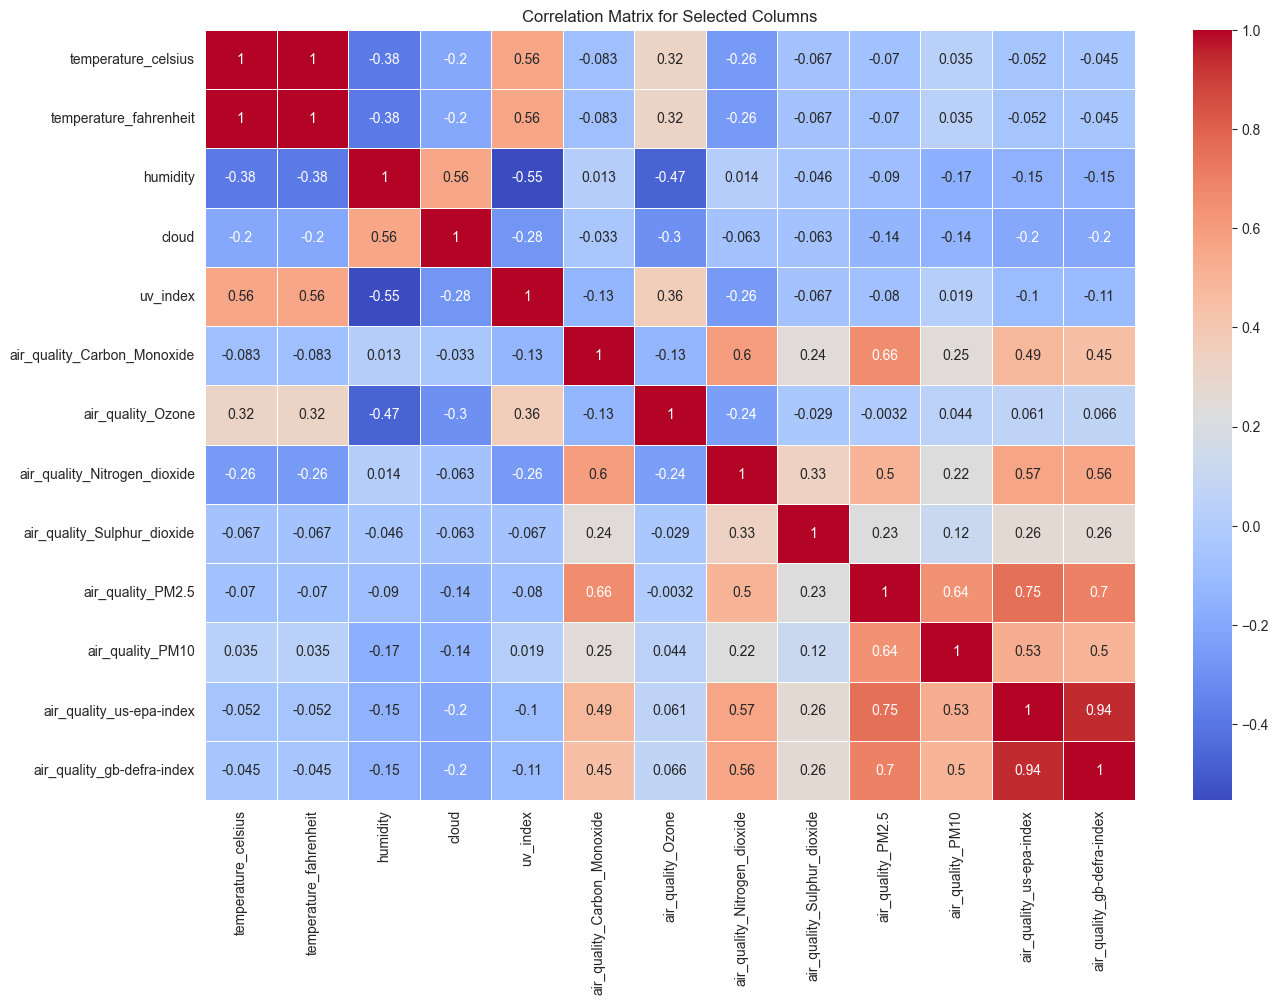

In [21]:
# Visualize correlations between numerical features using a heatmap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of specific columns to visualize
selected_columns = [
    'temperature_celsius', 'temperature_fahrenheit', 'humidity', 'cloud',
    'uv_index', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5',
    'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Select only the specified columns from the dataset
specific_data = data[selected_columns]

# Drop columns that are completely missing or have no variation
specific_data = specific_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
specific_data = specific_data.loc[:, specific_data.nunique() > 1]  # Drop columns with no variation

# Calculate the correlation matrix for the selected columns
correlation_matrix = specific_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Selected Columns')
plt.show()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Define the list of specific columns to visualize
selected_columns = [
    'temperature_celsius', 'temperature_fahrenheit', 'humidity', 'cloud',
    'uv_index', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5',
    'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Define dropdowns
country_dropdown = widgets.Dropdown(
    options=data['country'].unique().tolist(),
    description='Country:',
    layout=widgets.Layout(width='300px')
)

location_dropdown = widgets.Dropdown(
    options=[],  # Dynamically populated based on country selection
    description='Location:',
    layout=widgets.Layout(width='300px')
)

# Define an output area for the heatmap
output = widgets.Output()

# Update location dropdown based on country selection
def update_location_dropdown(change):
    selected_country = change['new']
    locations = data[data['country'] == selected_country]['location_name'].unique().tolist()
    location_dropdown.options = locations

# Attach the update function to the country dropdown
country_dropdown.observe(update_location_dropdown, names='value')

# Function to plot the heatmap
def plot_heatmap(country, location):
    # Filter the data based on the selected country and location
    data_filtered = data[(data['country'] == country) & (data['location_name'] == location)]

    # Select only the specified columns
    specific_data = data_filtered[selected_columns]

    # Drop columns that are completely missing or have no variation
    specific_data = specific_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
    specific_data = specific_data.loc[:, specific_data.nunique() > 1]  # Drop columns with no variation

    # Check if there is enough data for a correlation matrix
    if specific_data.empty or specific_data.shape[1] < 2:
        with output:
            output.clear_output()
            print("Not enough data to plot the heatmap.")
        return

    # Calculate the correlation matrix
    correlation_matrix = specific_data.corr()

    # Plot the heatmap
    with output:
        output.clear_output()
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Correlation Matrix for {country}, {location}')
        plt.show()

# Create a button for plotting the heatmap
plot_button = widgets.Button(
    description="Plot Heatmap",
    button_style='primary',
    layout=widgets.Layout(width='200px')
)

# Update the heatmap when the button is clicked
def on_plot_button_click(b):
    with output:
        output.clear_output(wait=True)
        plot_heatmap(country_dropdown.value, location_dropdown.value)

plot_button.on_click(on_plot_button_click)

# Display the controls and output
controls = widgets.VBox([country_dropdown, location_dropdown, plot_button])
display(widgets.HBox([controls, output]))


Number of samples in X: 48331
Number of labels in y: 48331
Feature Importance (CatBoost):
                         Feature  Importance
2                       uv_index   33.846412
5   air_quality_Nitrogen_dioxide   18.260583
4              air_quality_Ozone   12.025944
0                       humidity    9.108354
3    air_quality_Carbon_Monoxide    7.293437
1                          cloud    5.394771
8               air_quality_PM10    4.529913
6    air_quality_Sulphur_dioxide    4.181061
7              air_quality_PM2.5    3.768131
9       air_quality_us-epa-index    1.201613
10    air_quality_gb-defra-index    0.389782


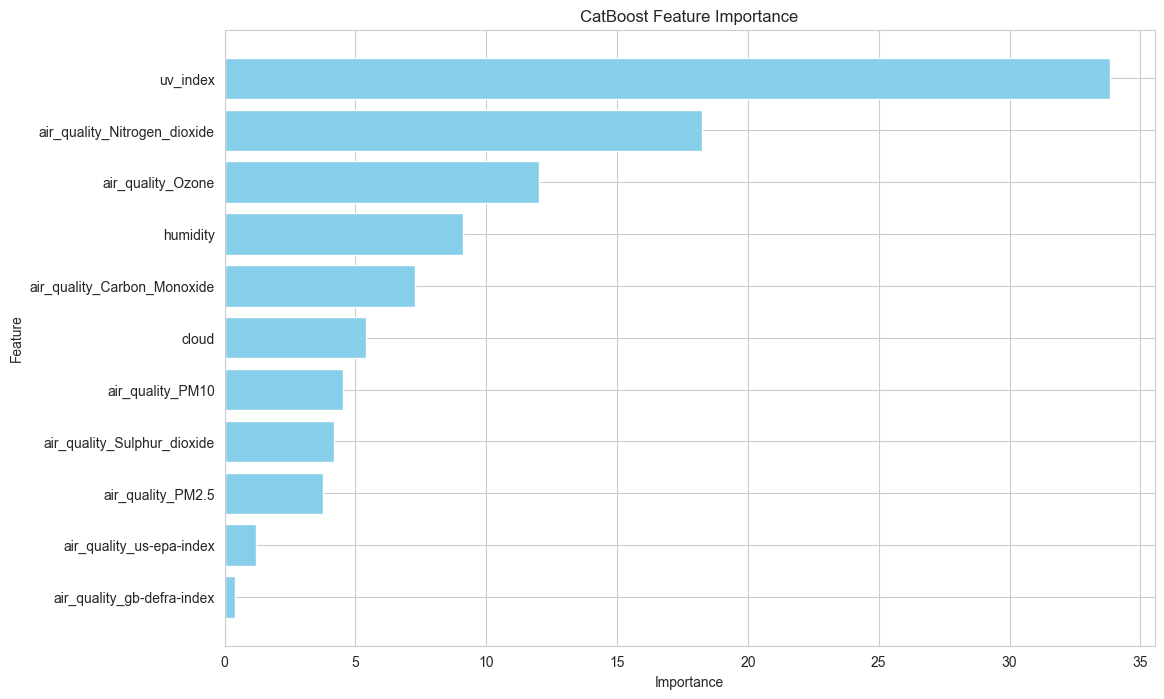

In [46]:
# Feature importance analysis using CatBoost
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

# Define the target and features
target = 'temperature_celsius'  # Replace with your target variable
features = [
    'humidity', 'cloud', 'uv_index',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]

# Handle missing values consistently
X = data[features].dropna()  # Drop rows with missing feature values
y = data[target].dropna()    # Drop rows with missing target values

# Ensure indices match between X and y
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Check lengths to ensure alignment
print(f"Number of samples in X: {len(X)}")
print(f"Number of labels in y: {len(y)}")

# Define and train the CatBoost model
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    silent=True
)
catboost_model.fit(X, y)

# Get feature importance
feature_importances = catboost_model.get_feature_importance(Pool(X, y))
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print("Feature Importance (CatBoost):")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()



SHAP Summary Plot:


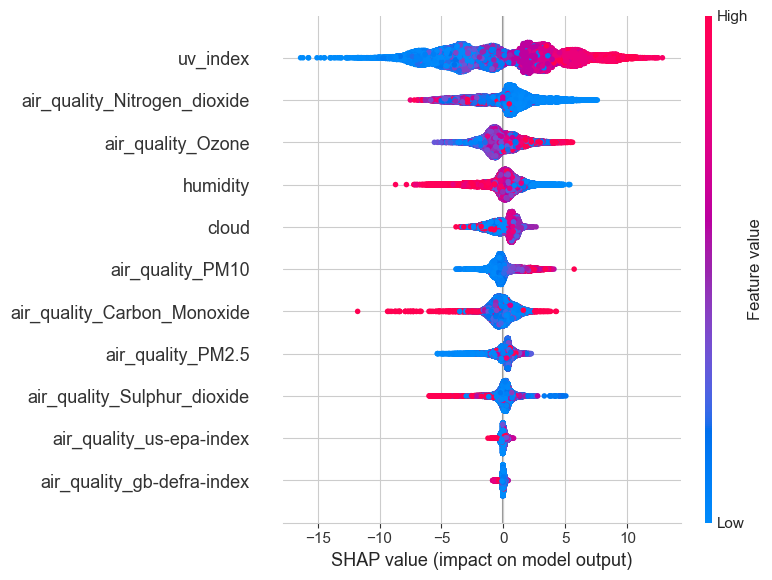

In [47]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X)

In [25]:
# !pip install geopandas folium shapely

In [48]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

# Inspect the data for required columns
print(data.head())

# Define columns for spatial analysis
latitude_col = 'latitude'
longitude_col = 'longitude'
attribute_col = 'temperature_celsius'  # Replace with the attribute to analyze


       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch        last_updated  temperature_celsius  \
0          1715849100 2024-05-16 13:15:00                 26.6   
1          1715849100 2024-05-16 10:45:00                 19.0   
2          1715849100 2024-05-16 09:45:00                 23.0   
3          1715849100 2024-05-16 10:45:00                  6.3   
4          1715849100 2024-05-16 09:45:00                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  P

<Figure size 1200x800 with 0 Axes>

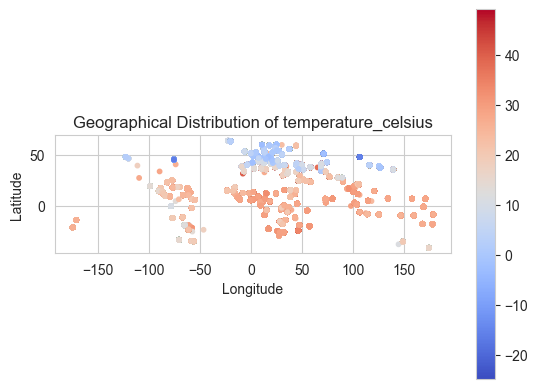

In [49]:
from shapely.geometry import Point

# Create a GeoDataFrame for spatial analysis
geometry = [Point(xy) for xy in zip(data[longitude_col], data[latitude_col])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry)

# Plot geographical patterns
plt.figure(figsize=(12, 8))
geo_df.plot(column=attribute_col, cmap='coolwarm', legend=True, markersize=10)
plt.title(f'Geographical Distribution of {attribute_col}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
